# Support vector machines

In [1]:
# import libraries

import numpy as np
import math
import pandas as pd

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.svm import LinearSVR
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score

## Data pre-processing

In [2]:
# load training data

# load data from csv file
df_train_features = pd.read_csv ('train_features.csv')
df_train_labels = pd.read_csv('train_labels.csv')

# Load test data
df_test_features = pd.read_csv ('test_features.csv')

 ### Histogram of the output labels 

We should check for class imbalance.

/Users/ahmadrezayousefkhani/Library/Python/3.7/lib/python/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/ahmadrezayousefkhani/Library/Python/3.7/lib/python/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/ahmadrezayousefkhani/Library/Python/3.7/lib/python/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.ro

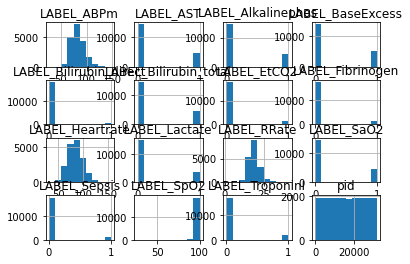

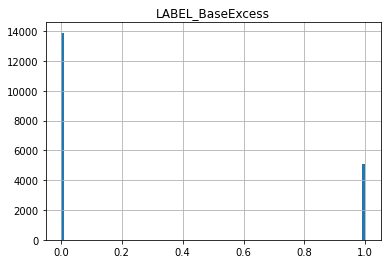

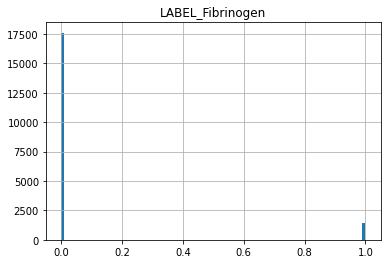

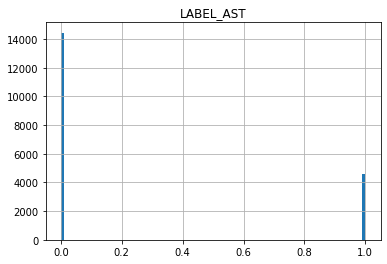

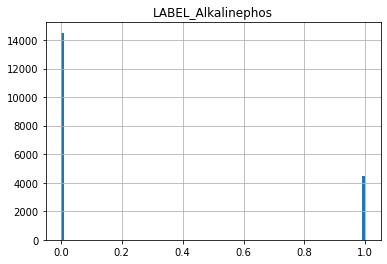

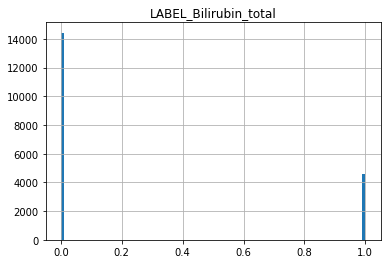

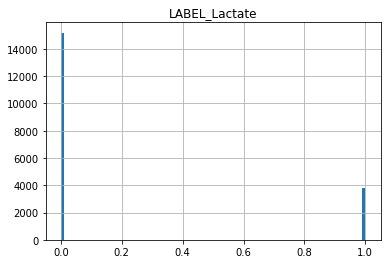

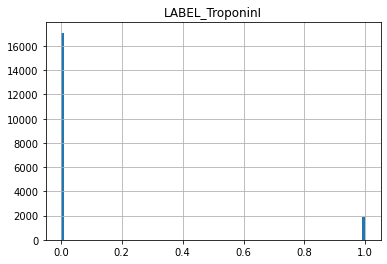

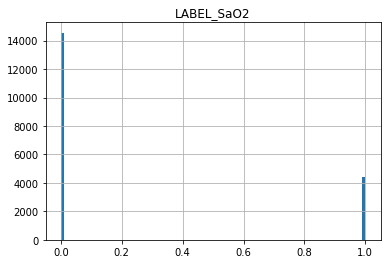

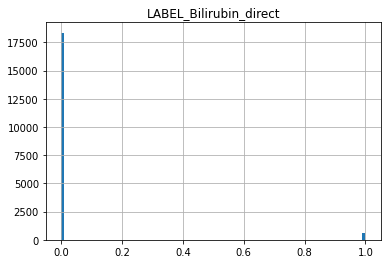

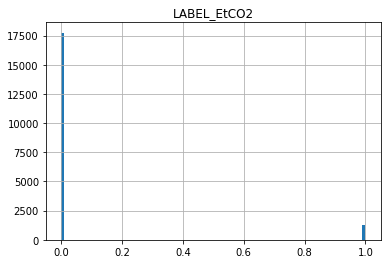

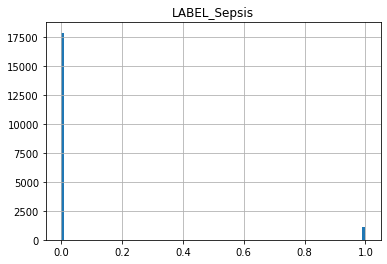

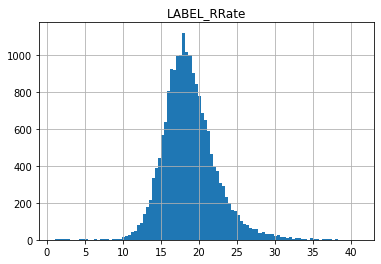

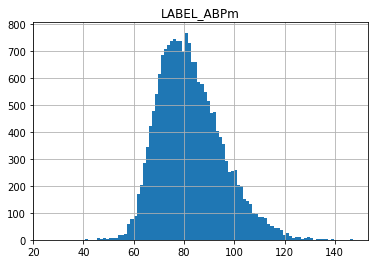

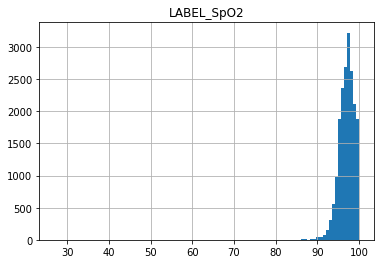

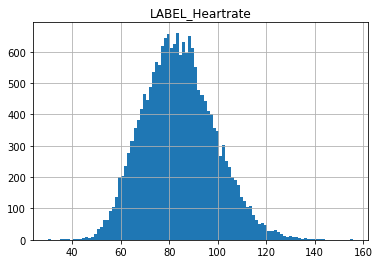

In [3]:
df_train_labels.hist()

with PdfPages("./Results/Labels_histogram.pdf") as export_pdf:
    for i in list(df_train_labels)[1:]:
        df_train_labels.hist(column = i, bins = 100)
        export_pdf.savefig()

One can see the class imbalance problem here. Other observations:
  * Heartrate, RRate, ABPm,  distribution is similar to a normal distribution
  * SpO2 is like a censored normal distribution. 
  * For all of the other features, class imbalance is an obvious problem.

A basic strategy that could be used here: Upsample both classes! Do the upsampling efficiently, not just replicating the datapoints

### Train Data pre-processing

In [4]:
# data inspection: 
#############################################
# range of the provided data?
print(df_train_features.agg([min, max]))

# how much missing data? 
print("number of missing values:")
print(df_train_features.isnull().sum(axis=0))

       pid  Time    Age  EtCO2    PTT    BUN  Lactate  Temp   Hgb  HCO3  ...  \
min      1     1   15.0   10.0   12.5    1.0      0.2  21.0   3.3   0.0  ...   
max  31658   315  100.0  100.0  250.0  268.0     31.0  42.0  23.8  50.0  ...   

     Alkalinephos   SpO2  Bilirubin_direct  Chloride   Hct  Heartrate  \
min          12.0   20.0              0.01      66.0   9.4       23.0   
max        3833.0  100.0             21.20     141.0  63.4      191.0   

     Bilirubin_total  TroponinI   ABPs    pH  
min              0.1       0.01   21.0  6.82  
max             46.5     440.00  287.0  7.78  

[2 rows x 37 columns]
number of missing values:
pid                      0
Time                     0
Age                      0
EtCO2               218157
PTT                 217641
BUN                 207835
Lactate             217184
Temp                146825
Hgb                 205645
HCO3                215381
BaseExcess          208053
RRate                40155
Fibrinogen          22544

### Train data pre-processing

In [5]:
# aggregate data for each pid
# GROUPBY REARRANGES THE ROWS, WE HAVE TO DO THE SAME FOR THE LABELS
df_train_aggregate_features = df_train_features.groupby('pid').agg('sum')

# print(df_train_aggregate_features)

In [6]:
# remove time from data frame 
df_train_agg_features = df_train_aggregate_features.drop(['Time'], axis = 1)
# print(df_train_agg_features)

In [7]:
# impute missing data points
imp = SimpleImputer(strategy="mean")
df_train_agg_imputed_features = imp.fit_transform(df_train_agg_features)
#print(df_train_agg_imputed_features)

In [8]:
# REARRANGE THE LABELS, TO MATCH THE REARRANGED FEATURES
df_train_labels_sorted = df_train_labels.sort_values(by = 'pid')
# print(df_train_labels_sorted)

### Test Data pre-processing

In [9]:
# data inspection: 
#############################################
# range of the provided data?
print(df_test_features.agg([min, max]))

# how much missing data? 
print("number of missing values:")
print(df_test_features.isnull().sum(axis=0))

       pid  Time    Age  EtCO2    PTT    BUN  Lactate  Temp   Hgb  HCO3  ...  \
min      0     1   16.0   10.0   18.1    1.0      0.3  27.0   2.3   0.0  ...   
max  31655   293  100.0  100.0  249.9  205.0     23.3  42.0  23.8  49.0  ...   

     Alkalinephos   SpO2  Bilirubin_direct  Chloride   Hct  Heartrate  \
min          11.0   22.0              0.01      74.0   9.1       21.0   
max        2121.0  100.0             21.00     145.0  71.7      184.0   

     Bilirubin_total  TroponinI   ABPs    pH  
min              0.1       0.01   28.0  6.62  
max             46.4     271.60  281.0  7.69  

[2 rows x 37 columns]
number of missing values:
pid                      0
Time                     0
Age                      0
EtCO2               145440
PTT                 145115
BUN                 138520
Lactate             144692
Temp                 97813
Hgb                 137096
HCO3                143546
BaseExcess          138730
RRate                26669
Fibrinogen          15031

### Test data pre-processing

In [10]:
# aggregate data for each pid
df_test_aggregate_features = df_test_features.groupby('pid').agg('sum')

#print(df_train_aggregate_features)

# collect all test pids
test_pids = list(set(df_test_features.pid))

In [11]:
# remove time from data frame 
df_test_agg_features = df_test_aggregate_features.drop(['Time'], axis = 1)
# print(df_test_agg_features)

In [12]:
# impute missing data points
df_test_agg_imputed_features = imp.transform(df_test_agg_features)

## Fit a model & Predict

### predict with support vector machine classification and use probabilities

In [17]:
# first for the labels that have an output [0,1]

columns_1 = [test_pids]

for i in range(1, 12):
    clf = SVC(kernel = 'poly', degree = 3, class_weight = 'balanced', verbose = True, probability = True)
    clf.fit(df_train_agg_imputed_features, df_train_labels_sorted.iloc[:,i])
    pred = clf.predict(df_test_agg_imputed_features)
    # proba = clf.predict_proba(df_test_agg_imputed_features)
    #columns.append(proba[:,1])
    columns_1.append(pred)
    

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [18]:
print(pred)

[1. 0. 0. ... 1. 0. 0.]


In [22]:
print(len(columns_1))

12


In [33]:
# labels that have a real value
columns_2 = []
scaler = StandardScaler().fit(df_train_agg_imputed_features)
X_train = scaler.transform(df_train_agg_imputed_features)

for i in range(12, 16):
    clf = SVR(kernel='rbf', gamma = 'auto' , C=1.0, epsilon=0.2, max_iter = 100000)
    clf.fit(X_train, df_train_labels.iloc[:,i])
    pred = clf.predict(scaler.transform(df_test_agg_imputed_features))
    columns_2.append(pred)

In [34]:
columns_final = columns_1 + columns_2


### predict with Support vector regression and then compute sigmoid function

In [20]:
# first for the labels that have an output [0,1]

columns = [test_pids]

for i in range(1,12):
    clf = LinearSVR(fit_intercept = True, max_iter = 1000)
    clf.fit(df_train_agg_imputed_features, df_train_labels.iloc[:,i])
    pred = clf.predict(df_test_agg_imputed_features)
    prob = np.empty(len(pred))
    for i in range(0, len(pred)):
        prob[i] = 1 / (1 + math.exp(-pred[i]))
    columns.append(prob)

/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

In [21]:
# labels that have a real value
for i in range(12, 16):
    clf = LinearSVR()
    clf.fit(df_train_agg_imputed_features, df_train_labels.iloc[:,i])
    pred = clf.predict(df_test_agg_imputed_features)
    columns.append(pred)

/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Save predictions

In [35]:
print(np.shape(columns_final))
result = pd.DataFrame(columns_final).transpose()
result.columns = list(df_train_labels)
result.to_csv('./Results/prediction.csv.zip', index=False, float_format='%.3f', compression='zip')

(16, 12664)


In [ ]:
result.to_csv('./Results/prediction.csv', index=False, float_format='%.3f')